## Import Packages

In [1]:
#importing some useful packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import os
import glob
import time
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
from sklearn.externals import joblib
import pickle
from sklearn.grid_search import GridSearchCV
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import matplotlib.cm as cm
%matplotlib inline

/home/lcf/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lcf/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Define functions to extract HOG features

In [16]:
def trans_RGB2other(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    return feature_image

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, show=False, feature_vec=True):
    if show:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = trans_RGB2other(image, cspace)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    show=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, show=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    return features

### Load train data

In [3]:
notcars = glob.glob('./non-vehicles/*/*.png')
cars = glob.glob('./vehicles/*/*.png')

### Set HOG parameter 

In [4]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 16 # 64%pix_per_cell==0
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

### Visualize some training data (raw image and hog images of differrent channel)

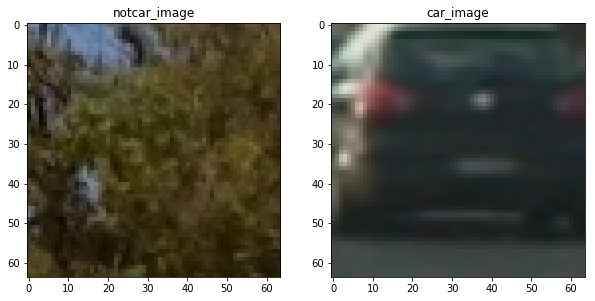

(64, 64, 3)


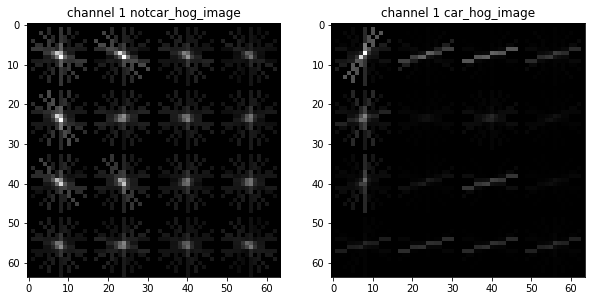

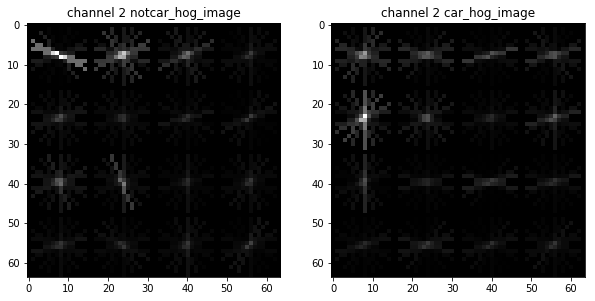

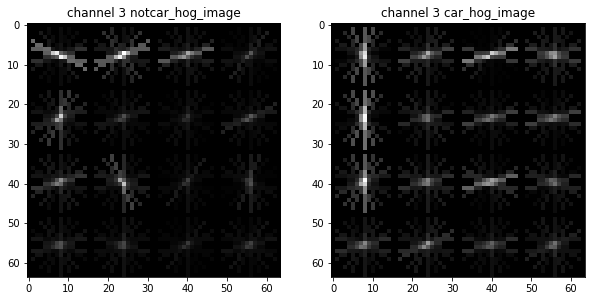

In [5]:
test_i = 4
notcar_image = mpimg.imread(notcars[test_i])
car_image = mpimg.imread(cars[test_i])
plt.figure(figsize=(10,20))
plt.subplot(121) 
plt.imshow(notcar_image)
plt.title('notcar_image')
plt.subplot(122) 
plt.imshow(car_image)
plt.title('car_image')
plt.show()   

notcar_feature_image = np.copy(notcar_image)
print(notcar_feature_image.shape)
notcar_feature_image = trans_RGB2other(notcar_image, colorspace)
car_feature_image = np.copy(car_image)
car_feature_image= trans_RGB2other(car_image, colorspace)
for i in range(3):
    notcar_features, notcar_hog_image = get_hog_features(notcar_feature_image[:,:,i],orient, pix_per_cell, cell_per_block,show=True, feature_vec=True)
    car_features, car_hog_image = get_hog_features(car_feature_image[:,:,i],orient, pix_per_cell, cell_per_block,show=True, feature_vec=True)

    plt.figure(figsize=(10,20))
    plt.subplot(121) 
    plt.imshow(notcar_hog_image,cmap='gray')
    plt.title('channel '+str(i+1)+' notcar_hog_image')
    plt.subplot(122) 
    plt.imshow(car_hog_image,cmap='gray')
    plt.title('channel '+str(i+1)+' car_hog_image')
    plt.show()      



### Image preprocessing

In [6]:

car_features = extract_features(cars, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features))
X = X.astype(np.float64)                       

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


print('Feature vector length:', len(X_train[0]))

Feature vector length: 972


### Train SVC and save the model

In [7]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy:', round(svc.score(X_test, y_test), 4))


train_dist={}
train_dist['clf']=svc
train_dist['scaler']=None
train_dist['orient']=orient
train_dist['pix_per_cell'] = pix_per_cell
train_dist['cell_per_block'] = cell_per_block
train_dist['hog_channel'] = hog_channel
train_dist['spatial_size'] = None
train_dist['hist_bins'] = None

output = open('train_dist.p', 'wb')
pickle.dump(train_dist,output)


Test Accuracy: 0.9809


In [17]:


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list




def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_windows(img,windows):
    draw_img = np.copy(img)
    for window in windows:
        cv2.rectangle(draw_img, window[0],window[1], (0, 0, 255), 6)
    return draw_img

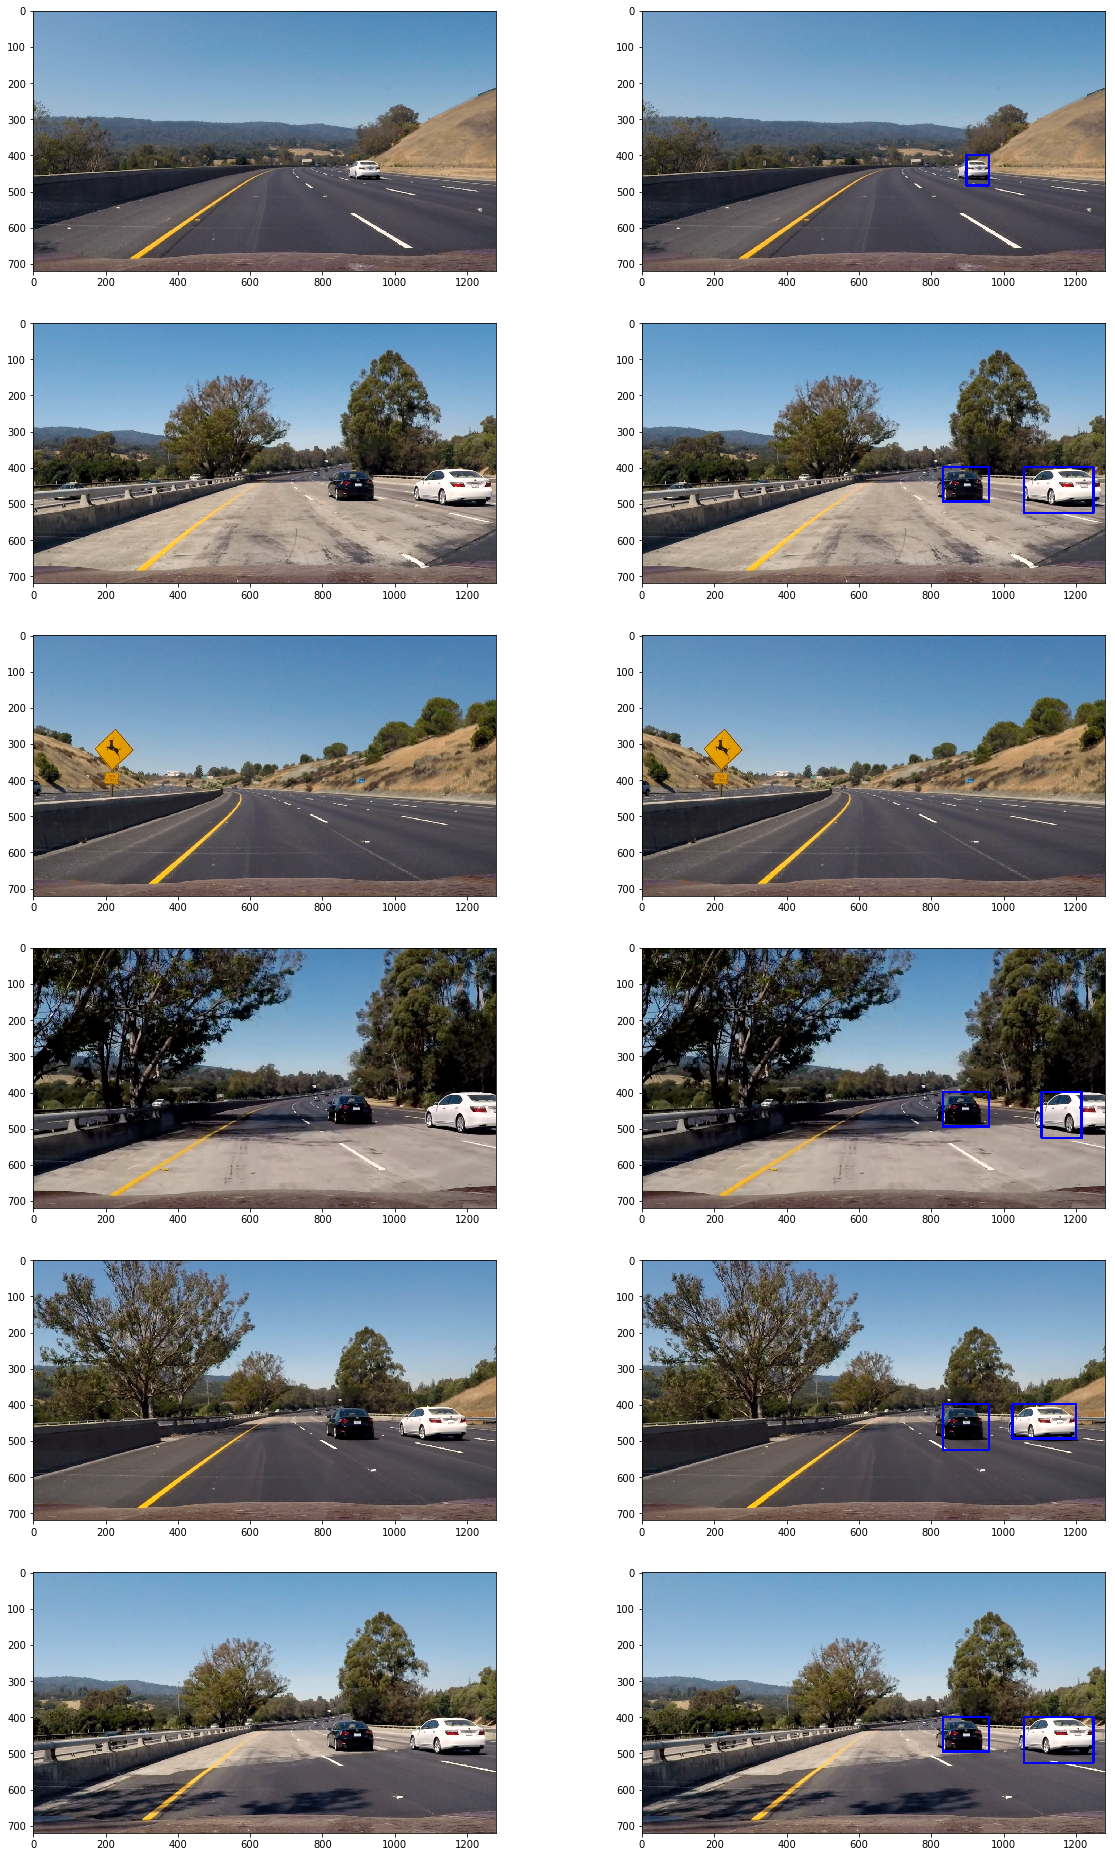

In [20]:



dist_pickle = pickle.load(open("train_dist.p", "rb"))
svc = dist_pickle["clf"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]




# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient,
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    # array of rectangles where cars were detected
    windows = []

    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]

    # apply color conversion if other than 'RGB'
    ctrans_tosearch = trans_RGB2other(img_tosearch, cspace) 
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # select colorspace channel for HOG
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]
    else:
        ch1 = ctrans_tosearch[:, :, hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1  # -1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1  # -1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell


            hog_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(hog_features)

            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                windows.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return windows

def search_car(img):
    draw_img = np.copy(img)
    windows = []


    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 16 # 64%pix_per_cell==0
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    search_areas = [[400,480,1.0],[420,500,1.0],[400,496,1.5],[432,528,1.5],[400,528,2.0],[432,560,2.0],[400,596,3.0],[464,660,3.0]]
    
    for i in range(len(search_areas)):
        windows+=(find_cars(img, search_areas[i][0], search_areas[i][1], search_areas[i][2], colorspace, hog_channel, svc, None,
                                orient, pix_per_cell, cell_per_block, None, None, False))

    
#    window_list = slide_window(img)

    
    heat_map = np.zeros(img.shape[:2])
    heat_map = add_heat(heat_map,windows)
#     plt.imshow(heat_map, cmap=cm.hot)
    plt.show()
    heat_map_thresholded = apply_threshold(heat_map,1)
    labels = label(heat_map_thresholded)
    draw_img = draw_labeled_bboxes(draw_img,labels)
    
#     draw_img = draw_windows(draw_img,windows)
    return draw_img

ystart = 400
ystop = 656
scale = 1.5

test_imgs=[]
out_imgs = []
img_paths = glob.glob('test_images/*.jpg')
# plt.figure(figsize=(20,68))
for path in img_paths:
    img = mpimg.imread(path)
#    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
#                    hist_bins)
    out_img = search_car(img)
    test_imgs.append(img)
    out_imgs.append(out_img)

plt.figure(figsize=(20,68))
for i in range(len(test_imgs)):
    plt.subplot(2*len(test_imgs),2,2*i+1)
#    plt.title('before thresholds')
    plt.imshow(test_imgs[i])

    plt.subplot(2*len(test_imgs),2,2*i+2)
#    plt.title('after thresholds')
    plt.imshow(out_imgs[i])

## Test on Videos

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    result = search_car(image)
    return result

In [21]:
white_output = 'test_videos_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4



 12%|█▏        | 152/1261 [00:31<03:53,  4.75it/s]


 24%|██▍       | 303/1261 [01:04<03:23,  4.72it/s]


 36%|███▌      | 454/1261 [01:37<02:51,  4.70it/s]


 48%|████▊     | 605/1261 [02:09<02:20,  4.67it/s]


 60%|█████▉    | 756/1261 [02:42<01:53,  4.43it/s]


 72%|███████▏  | 907/1261 [03:14<01:15,  4.72it/s]


 84%|████████▍ | 1057/1261 [03:47<00:43,  4.66it/s]


 96%|█████████▌| 1205/1261 [04:19<00:11,  4.69it/s]


100%|█████████▉| 1260/1261 [04:31<00:00,  4.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 7min 8s, sys: 2.97 s, total: 7min 11s
Wall time: 4min 31s


Play the video inline.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))